<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="./images/DLI_Header.png"></a></div>

# Alternating Least Squares

Previously, we learned about content-based filters, which earns it's name from how it makes predictions based on the content of the item it's making a prediction for. But what if we don't have a subject matter expert to define categories for us?

In that case, we can try [collaborative filtering](http://recommender-systems.org/collaborative-filtering/), where predictions are generated based on the tastes of similar users.

## Objectives
This notebook demonstrates:
* How to build a collaborative filter using alternating least squares
  * [1. Dealing with Sparsity](#1.-Dealing-with-Sparsity)
  * [2. Matrix Factorization](#2.-Matrix-Factorization)
* How to use a collaborative filter for recommendation
  * [3. Alternating Least Squares](#3.-Alternating-Least-Squares)
  * [4. Convergence and Regularization](#4.-Convergence-and-Regularization)
  * [5. Wrap Up](#5.-Wrap-Up)

## 1. Dealing with Sparsity
Recommender Systems are often built for [sparse data](https://en.wikipedia.org/wiki/Sparse_matrix). Few people have seen every Netflix movie, played every Steam game, rated everything on Amazon, or have eaten at every restaurant.

Even for our toy example, our users haven't tried every candy.

User | M&Ms | Skittles | Snickers | Laffy Taffy | Caramel Chew
-|-|-|-|-|-
Lara| 3 | - | 5 | - | -
Daisy| 4 | - | - | 1 | -
Alyx | - | - | - | - | 5
Sarah | - | 3 | 2 | - | -

Sparse data means that relatively few cells have an entry. Both NumPy and CuPy's default arrays are dense, which means in the data structure, each cell has allocated memory to store a value. If we have millions of items or users, this can end up taking large amounts of memory to process.

In order to efficiently deal with sparse data, we're going to use [CuPy Sparse Arrays](https://docs-cupy.chainer.org/en/stable/reference/sparse.html). Let's load in the necessary libraries to do this.

In [1]:
import cudf
import cupy as cp
import cupyx.scipy.sparse
import numpy as np
import matplotlib.pyplot as plt

Let's also load in our toy data from before to get a sense of how sparse data works.

In [2]:
ratings = cudf.DataFrame({
    'user': ["Lara", "Lara", "Daisy", "Daisy", "Alyx", "Sarah", "Sarah"],
    'item': ["m_ms", "snickers", "m_ms", "laffy_taffy", "caramel_chew", "skittles", "snickers"],
    'rating': [3, 5, 4, 1, 5, 3, 2]})

ratings

,user,item,rating
0,Lara,m_ms,3
1,Lara,snickers,5
2,Daisy,m_ms,4
3,Daisy,laffy_taffy,1
4,Alyx,caramel_chew,5
5,Sarah,skittles,3
6,Sarah,snickers,2


There are many ways to encode a sparse matrix. We'll be using the [coordinated list (COO)](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)) format. The [CuPy COO Matrix](https://docs-cupy.chainer.org/en/stable/reference/generated/cupyx.scipy.sparse.coo_matrix.html) takes three lists:
1. The row index for each value
2. The column index for each value
3. The value corresponding to the row and column indexes in list 1 and 2

As it turns out, our `ratings` DataFrame is close to this format, but our indexes should be numbers, not strings.

A quick way to convert `ratings` would be to use [factorize](https://docs.rapids.ai/api/cudf/stable/api_docs/api/cudf.Series.factorize.html), which will assign a number to each unique value. It will also return a mapping in case we want to convert from one to the other.

In [3]:
ratings["user"].factorize()

(0    2
 1    2
 2    1
 3    1
 4    0
 5    3
 6    3
 dtype: int8,
 0     Alyx
 1    Daisy
 2     Lara
 3    Sarah
 Name: user, dtype: object)

In [4]:
user_indexes, user_mapping = ratings["user"].factorize()
item_indexes, item_mapping = ratings["item"].factorize()

Next, we'll [convert the data to CuPy](https://docs.rapids.ai/api/cudf/stable/user_guide/10min-cudf-cupy.html#Converting-a-cuDF-DataFrame-to-a-CuPy-Array) and normalize the data before putting into a COO sparse array. This time we'll use a -1 to 1 scale to better plot the embeddings, but a 0 to 1 scale is also valid.

In [5]:
row = cp.asarray(user_indexes)
column = cp.asarray(item_indexes)
data = cp.asarray(ratings["rating"], dtype=np.float32)

# Normalize Data
min_rating = 1
max_rating = 5
data = 2 * (data - min_rating) / (max_rating - min_rating) - 1

sparse_ratings = cupyx.scipy.sparse.coo_matrix((data, (row, column)))

sparse_ratings

Because of the way this data is structured, it's hard to render and therefore, hard to debug. While we're learning and testing we can use the [todense](https://docs-cupy.chainer.org/en/stable/reference/generated/cupyx.scipy.sparse.coo_matrix.html#cupyx.scipy.sparse.coo_matrix.todense) method to render the matrix.

When we use our Amazon dataset however, we won't be using this method to check our data. It would take up too much memory and will significantly slow down our machines. The trick to efficiently using sparse data in real world situations is to build [good unit tests](https://docs.python.org/2/library/unittest.html) to test portions of the data pipeline using small, fake datasets to verify that the functions are working correctly.

In [6]:
sparse_ratings.todense()

array([[ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -1. ,  0.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. , -0.5]], dtype=float32)

When we normalized our data, some scores were converted to `0`. `0` can be a valid rating, and it would be good to have a way to differentiate it from a missing score.

To do that, let's create a `mask` of `1`s to signify a rating versus no rating.

In [7]:
data = cp.asarray([1 for _ in range(len(ratings["rating"]))], dtype=np.float32)
sparse_mask = cupyx.scipy.sparse.coo_matrix((data, (row, column)))

sparse_mask.todense()

array([[1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1.]], dtype=float32)

## 2. Matrix Factorization

One way to build a collaborative filter is [matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)). If multiplying a matrix with `u x k` dimensions with a matrix of `k x i` dimensions produces a `u x i` matrix, maybe we can do the reverse process. Maybe we can break down a `u x i` matrix into a `u x k` matrix and a `k x i` matrix.

This is appealing for a couple of reasons
* As long as `k` is small, it would take less memory to store data in the two factors compared to the whole matrix.
* Prediction is fast. We can predict any rating by taking the dot product of the factors for each respective user and item.

The `k` here is called an [embedding](https://en.wikipedia.org/wiki/Embedding). Much like the embeddings for neural networks, its goal is to represent more data with less.

For instance, let's set our `embeddings` to `2`. This means for each user, we're going to find a way to represent them using `2` numbers. We'll initialize our embedding with [random values](https://docs-cupy.chainer.org/en/stable/reference/generated/cupy.random.rand.html#cupy.random.rand) for now, and convert their range to be `-1` to `1`.

In [8]:
embeddings = 2
shape = (len(user_mapping), len(item_mapping))

In [9]:
def initalize_features(length, embeddings):
    return cp.random.rand(embeddings, length) * 2 - 1

user_features = initalize_features(shape[0], embeddings)

user_features

array([[ 0.5755336 ,  0.84119932, -0.77876732,  0.17344912],
       [ 0.91816243, -0.31250391,  0.39226113,  0.29544523]])

Similarly, we'll find a way to represent each item with `2` numbers.

In [10]:
item_features = initalize_features(shape[1], embeddings)

item_features

array([[-0.24535422, -0.95117305,  0.60658512,  0.10363079, -0.78119519],
       [-0.96580853, -0.34417651,  0.41676679,  0.25892023, -0.82801584]])

If we want to make a prediction for a user and an item, we take their respective embeddings and take the [dot product](https://en.wikipedia.org/wiki/Dot_product#Geometric_definition). For instance, if we want to make a prediction for Laura (index 2) and for Skittles (index 3), we can do this.

In [11]:
lara = user_mapping[user_mapping == "Lara"].index[0]
skittles = item_mapping[item_mapping == "skittles"].index[0]

cp.dot(user_features[:, lara].T, item_features[:, skittles])

array(0.02086007)

Or, if we want to do things in bulk, we can find predictions for every user-item combination by multiplying the full embeddings.

In [12]:
cp.dot(user_features.T, item_features)

array([[-1.02797871, -0.86344199,  0.73176972,  0.29737383, -1.20985712],
       [ 0.09542714, -0.69256961,  0.38001774,  0.00626057, -0.39838267],
       [-0.1877753 ,  0.60573541, -0.30890726,  0.02086007,  0.28357085],
       [-0.3279    , -0.26666544,  0.22834341,  0.09447142, -0.38013095]])

This works because the dot product includes a measure of similarity between the two vectors being multiplied. The closer one vector can be expressed as a ratio of the other vector, the higher the predicted rating will be. 

Another cool property of these matrix factorization embeddings is that we can graph both users and items onto the same coordinate plane. The closer a user is to an item, the more their tastes are aligned. Let's build a function to do this.

In [13]:
cp.array(user_features[1, :])

array([ 0.91816243, -0.31250391,  0.39226113,  0.29544523])

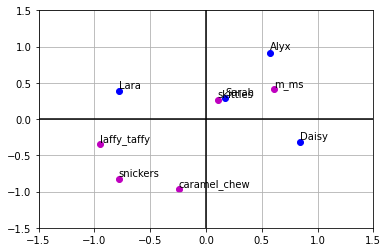

In [14]:
def plot_embeddings(user_features, item_features, user_mapping, item_mapping):
    offset = .04
    map_range = 1.5
    point_colors = ['b', 'm']
    
    grouping = [[user_features, user_mapping.values_host], [item_features, item_mapping.values_host]]
    fig, ax = plt.subplots()
        
    # Formating to make it look nice
    plt.ylim(-map_range, map_range)
    plt.xlim(-map_range, map_range)
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    
    #Find coordinates
    for idx, group in enumerate(grouping):
        features, mapping = group
        x = cp.asnumpy(features[0, :])
        y = cp.asnumpy(features[1, :])
        
        color = point_colors[idx]
        ax.scatter(x, y, color=color)

        for i, txt in enumerate(mapping):
            ax.annotate(txt, (x[i], y[i]+offset))

plot_embeddings(user_features, item_features, user_mapping, item_mapping)

These are just random values though. Let's train our embeddings to see how these points move over time.

## 3. Alternating Least Squares

There are many ways to perform [matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)#Techniques). One popular way to do so is [alternating least squares (ALS)](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe). It is popular because it scales well for large datasets and our embeddings are only trained on cells with a rating in our user-item interaction matrix. Other techniques need to find a way to cope with missing values.

It's called alternating least squares because for each rating, our goal is to minimize the square of the distance between our predictions and the true rating:

<img src="images/ALS.png" width="500" height="500">

We have two variables we can play with to minimize this function: our `user_features` (p) and our `item_features` (q). Rather than try to find the optimal values for both of them at the same time, we'll alternate between one and the other. We'll start by taking the derivative of the ALS function with respect to p, keeping q constant. When we set the derivative to 0, this will help us find the minimum value for p given our current value for q.

Solving for this equation, we end up with:

<img src="images/ALS_P.png" width="200" height="100">

Similarly, we can do the same for q:

<img src="images/ALS_Q.png" width="250" height="125">

Let's put this in practice and solve for `user_features`, breaking it down one step at a time. First, we'll solve for the numerator by multiplying each rating in each column by that corresponding column's embedding in `item_features` and adding them together. By default, empty sparse cells have a value of `0`, so we can use a dot product to really speed things up.

In [15]:
numerator = sparse_ratings.dot(item_features.T)

numerator

array([[-0.24535422, -0.96580853],
       [ 1.25446561,  0.55255991],
       [-0.78119519, -0.82801584],
       [ 0.39059759,  0.41400792]])

For the denominator, we'll need the embeddings for each item feature multiplied with itself. That's just the embedding squared.

In [16]:
squared_features = (item_features**2).sum(axis=0)

squared_features

array([0.99298481, 1.02318763, 0.54164006, 0.07777903, 1.29587616])

Finally, we want to find the corresponding `item_feature` embedding for each rating we used in the numerator. We can take advantage of our `sparse_mask` where we have a `1` for each rating. We can also use the dot product to find the sum of all of those squared embeddings quickly.

In [17]:
denominator = sparse_mask.dot(squared_features)

denominator

array([0.99298481, 1.5648277 , 1.83751622, 1.37365518])

With this, we can divide the numerator with the denominator and take the [transpose](https://docs-cupy.chainer.org/en/stable/reference/generated/cupy.transpose.html) to build our new user features. In order to broadcast the division to each row, we'll add a [new axis](https://numpy.org/doc/stable/reference/constants.html#numpy.newaxis) to the denominator with `None`.

In [18]:
user_features = (numerator / denominator[:, None]).T

user_features

array([[-0.24708759,  0.80166373, -0.42513648,  0.28434908],
       [-0.97263173,  0.3531123 , -0.45061689,  0.30139145]])

We're going to go back and forth between our `user_features` and our `item_features` repeating the same process, so let's make a function to make our lives easier.

In [19]:
def als(values, mask, features):
    numerator = values.dot(features.T)
    squared_features = (features ** 2).sum(axis=0)
    denominator = mask.dot(squared_features)
    return (numerator / denominator[:, None]).T

item_features = als(sparse_ratings.T, sparse_mask.T, user_features)

item_features

array([[-0.24535422, -1.04471306,  0.34820135,  0.        , -1.02128437],
       [-0.96580853, -0.46016929,  0.15337376,  0.        , -1.08249469]])

Before we begin, we should also make a function to test how well our model is learning. Let's make a function to calculate the Root Mean Square Error (RMSE) as our goal is to minimize the squared error.

In [20]:
def rmse(user_features, item_features, sparse_mask, sparse_ratings):
    predictions = cp.matmul(user_features.T, item_features) * sparse_mask.todense()
    squared_error = ((predictions - sparse_ratings.todense()) ** 2).sum() ** 0.5
    
    return squared_error / sparse_mask.sum()

Time for our hard work to pay off! Run the cell below over and over until there's little change in the RMSE.

User Features [[-0.24708759  0.84175193 -0.43282387  0.23055733]
 [-0.97263173  0.37077012 -0.45876502  0.2443757 ]]
Item Features [[-0.24535422 -0.99495889  0.33837406  0.         -1.073284  ]
 [-0.96580853 -0.43825386  0.14904509  0.         -1.1376109 ]]
RMSE: 0.03848056407507422


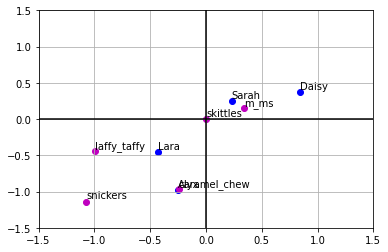

In [21]:
user_features = als(sparse_ratings, sparse_mask, item_features)
item_features = als(sparse_ratings.T, sparse_mask.T, user_features)

print("User Features", user_features)
print("Item Features", item_features)
print ("RMSE:", rmse(user_features, item_features, sparse_mask, sparse_ratings))

plot_embeddings(user_features, item_features, user_mapping, item_mapping)

## 4. Convergence and Regularization

ALS may not converge, and that's expected. Check out [this article](https://www.sciencedirect.com/science/article/pii/S0024379511007828) for a full mathematical explanation as for why and an investigation to find proof of convergence [here](https://pdfs.semanticscholar.org/4267/ab9c6380bb057079570e1705f3ca66cb205a.pdf).

The short answer is that it greatly helps to provide a boundary that our features can be in. In other words, regularization is not just useful to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting), but also helps with convergence.

For ALS, this is done by minimizing the length of the feature vectors as scaled by our regularization parameter, lambda. This is our new minimizing function:

<img src="images/ALS_R.png" width="500" height="300">

When we take the derivative of this function, lambda becomes the base value to scale our features:

<img src="images/ALS_RP.png" width="250" height="100">
<img src="images/ALS_RQ.png" width="250" height="100">

Let's update our `als` function to reflect this by adding a `scale` parameter. (Lambda is already a key word in python).

In [22]:
def als(values, mask, features, scale=0.01):
    numerator = values.dot(features.T)
    squared_features = (features ** 2).sum(axis=0)
    denominator = scale + mask.dot(squared_features)
    return (numerator / denominator[:, None]).T

Let's also reinitialize our embeddings for a clean start.

In [23]:
user_features = cp.random.rand(embeddings, shape[0])
item_features = cp.random.rand(embeddings, shape[1])

Please run the below cell a few times until the RMSE converges. Did the scaling help? Try experimenting with the `scale` variable to see how it impacts the results.

RMSE: 0.05780218094360902


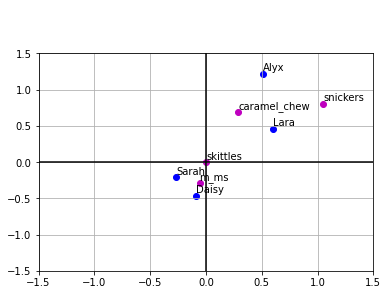

In [24]:
scale =.01
user_features = als(sparse_ratings, sparse_mask, item_features, scale)
item_features = als(sparse_ratings.T, sparse_mask.T, user_features, scale)

print ("RMSE:", rmse(user_features, item_features, sparse_mask, sparse_ratings))
plot_embeddings(user_features, item_features, user_mapping, item_mapping)

## 5. Wrap Up

Ready for the real deal? Let's give ALS a shot with our Amazon data! Please run the cell below to restart the kernel before moving on to the next <a href="1-06_als_real_data.ipynb">notebook</a>.

In [25]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="./images/DLI_Header.png"></a></div>